In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import seaborn as sns

import sys
import os
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs, pad_select, pad_seqs

ModuleNotFoundError: No module named 'matplotlib'

# RNN

In [2]:
import torch
import math
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())


True
True


In [3]:
dtype = torch.float
device = torch.device("mps")

# Create random input and output data
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# Randomly initialize weights
a = torch.randn((), device=device, dtype=dtype)
b = torch.randn((), device=device, dtype=dtype)
c = torch.randn((), device=device, dtype=dtype)
d = torch.randn((), device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(2000):
    # Forward pass: compute predicted y
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(t, loss)

# Backprop to compute gradients of a, b, c, d with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # Update weights using gradient descent
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d


print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

99 5744.87890625
199 3877.65283203125
299 2620.77001953125
399 1773.962158203125
499 1202.9041748046875
599 817.432373046875
699 556.9771728515625
799 380.8152770996094
899 261.54296875
999 180.7032012939453
1099 125.85308837890625
1199 88.5964126586914
1299 63.261783599853516
1399 46.015098571777344
1499 34.26091384887695
1599 26.24101448059082
1699 20.762672424316406
1799 17.016172409057617
1899 14.451088905334473
1999 12.692848205566406
Result: y = 0.05066697299480438 + 0.8180472254753113 x + -0.008740898221731186 x^2 + -0.08782657235860825 x^3


In [2]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]


def train(sequence,label,model,optimizer,criterion):

    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    for i in range(len(sequence[0])):
        output, hidden = model.forward(sequence[0][i], hidden)
    #Compare final output to target
    loss = criterion(output,label)#.long())
    #Back-propagate
    loss.backward()
    optimizer.step()

    return output, loss.item()

def run(model, train_data, epochs):

    model.train()
    loss_history = []
    for epoch in range(epochs):
        lossTotal = 0
        for x,y in train_data:
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history.append(lossTotal)

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history

def run_acc(model, train_data, test_data, epochs, verbose = False):

    model.train()
    loss_history = []
    acc_history = []
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
            if (epoch%100 == 2):
                if i%50 == 0:
                    if verbose:
                        print('\n################\nepoch: ',epoch, '\n################\n')
                        print('output =. ' , output.detach().numpy())
                        print('label =. ' , y.detach().numpy())
                        test_acc(model, test_data, hidden_size, verbose = True)
        loss_history.append(lossTotal)
        acc = test_acc(model, test_data, hidden_size)
        acc_history.append(acc)

    print(f'loss: {round(lossTotal,1)} ')
    print(f'accuracy: {round(acc,2)} ')
    return loss_history, acc_history



def run_cvrmse(model, train_data, epochs):

    model.train()
    rmse_history = []
    for epoch in range(epochs):
        lossTotal = 0
        ylog = 0
        for x,y in train_data:
            ylog += y.mean().item()
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        rmse = (lossTotal/len(train_data))**0.5 # root mean square error
        cvrmse = rmse/(ylog/len(train_data))
        rmse_history.append(cvrmse)

    print(f'cv rmse: {round(cvrmse,2)} ')
    return rmse_history


def test_model(model, testdata, hidden_size, verbose=False):
    model.eval()
    SSE = 0
    yvals = []
    for x,y in testdata:
        yvals.append(y.item())
        hidden = torch.zeros(1, hidden_size)[0]
        for step in x[0]:
            hidden, y_hat = model.get_activations(step,hidden)
        SE = (y.item() - y_hat.detach().item())**2 # squared error
        SSE += SE # sum of square error
    RMSE = (SSE/len(yvals))**0.5
    CV_RMSE = 100*RMSE/np.mean(yvals)
    
    return CV_RMSE

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    correct = 0
    for x,y in testdata:
        hidden = torch.zeros(1, hidden_size)[0]
        for step in x[0]:
            hidden, y_hat = model.get_activations(step,hidden)
        correct += sum(torch.round(y) == torch.round(y_hat)).item()/len(y)
    acc = correct/len(testdata)
    
    if verbose:
        print('test accuracy: %f ' % (acc))

    return acc

def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t
    

In [57]:
# Generate data

operators = ['+', '*']
input_ids = ['A', 'B', 'C', 'D'] # 2, 3
init_values = ['A', 'B', 'C', 'D']

# generate trial data
batchsize = 1
scale = 1
#halfscale = int(scale/2)
len_seq = 1

## single position
seqs = generate_sequences(operators, input_ids, len_seq, init_values = init_values, rand = False)
padseqs1 = pad_select(seqs, [0])
train_inputs1 = convert_seq2inputs(padseqs1*scale, num_classes=13, seq_len=8)
train_data1 = DataLoader(train_inputs1, batch_size=batchsize, shuffle=True)

seqs = generate_sequences(operators, input_ids, len_seq, init_values = init_values, rand = False)
padseqs2 = pad_select(seqs, [1])
train_inputs2 = convert_seq2inputs(padseqs2*scale, num_classes=13, seq_len=8)
train_data2 = DataLoader(train_inputs2, batch_size=batchsize, shuffle=True)

seqs = generate_sequences(operators, input_ids, len_seq, init_values = init_values, rand = False)
padseqs3 = pad_select(seqs, [2])
train_inputs3 = convert_seq2inputs(padseqs3*scale, num_classes=13, seq_len=8)
train_data3 = DataLoader(train_inputs3, batch_size=batchsize, shuffle=True)

## train on two positions
train_inputs123 = convert_seq2inputs(padseqs1*4 + padseqs2*4 + padseqs3*4, num_classes=13, seq_len=8)
train_data123 = DataLoader(train_inputs123, batch_size=batchsize, shuffle=True)

## train on two positions
len_seq=2
seqs = generate_sequences(operators, input_ids, len_seq, init_values = init_values, rand = False)
train2step, test2step = train_test_split(seqs, 0.1)
padseqs_2step = pad_seqs(seqs)
train_inputs_2step = convert_seq2inputs(padseqs_2step, num_classes=13, seq_len=8)
train_2step = DataLoader(train_inputs_2step, batch_size=batchsize, shuffle=True)



print('train 123: ', len(train_data123))
print('train 2 step: ', len(train_2step))


TypeError: Singleton array array(0.1) cannot be considered a valid collection.

In [55]:
len(padseqs_2step)

768

In [56]:
4*2*4*2*4

256

In [22]:
# train on 1 position

num_classes = 14
input_size = num_classes
output_size = batchsize
hidden_size = 20
num_layers = 1
learningRate = 0.0005
epochs = 400

num_sims = 10

losses=[]
accs = []

for j in range(num_sims):
    print('### rep', j, ' ###')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model, train_data123, train_2step, epochs)
    loss2, acc2 = run_acc(model, train_2step, train_2step, epochs)
    losses.append(loss1+loss2)
    accs.append(acc1+acc2)


### rep 0  ###
loss: 0.2 
accuracy: 0.0 
loss: 1.9 
accuracy: 0.98 
### rep 1  ###
loss: 0.0 
accuracy: 0.0 
loss: 2.2 
accuracy: 1.0 
### rep 2  ###
loss: 0.2 
accuracy: 0.0 
loss: 1.7 
accuracy: 1.0 
### rep 3  ###
loss: 0.1 
accuracy: 0.0 
loss: 1.3 
accuracy: 1.0 
### rep 4  ###
loss: 0.0 
accuracy: 0.0 
loss: 1.9 
accuracy: 1.0 
### rep 5  ###
loss: 0.0 
accuracy: 0.0 
loss: 3.5 
accuracy: 1.0 
### rep 6  ###
loss: 0.1 
accuracy: 0.0 
loss: 6.6 
accuracy: 1.0 
### rep 7  ###
loss: 0.2 
accuracy: 0.0 
loss: 7.6 
accuracy: 0.97 
### rep 8  ###
loss: 1.1 
accuracy: 0.0 
loss: 3.7 
accuracy: 1.0 
### rep 9  ###
loss: 0.0 
accuracy: 0.0 
loss: 5.0 
accuracy: 1.0 


Text(0, 0.5, 'accuracy')

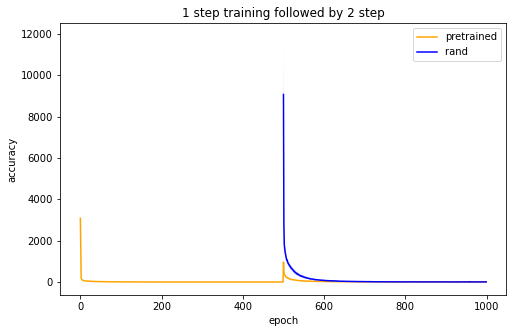

In [44]:
lr = np.array(losses).T
r = np.array(losses_rand).T
plt.figure(figsize=(8,5))
NNplt.plotNN_shifted([lr],\
                    labels = ['pretrained'],\
                    colors = ['orange'],\
                    shift = 0)
NNplt.plotNN_shifted([r],\
                    labels = ['rand '],\
                    colors = ['blue'],\
                    shift = 500)
plt.title('1 step training followed by 2 step')
plt.ylabel('accuracy')

Text(0, 0.5, 'accuracy')

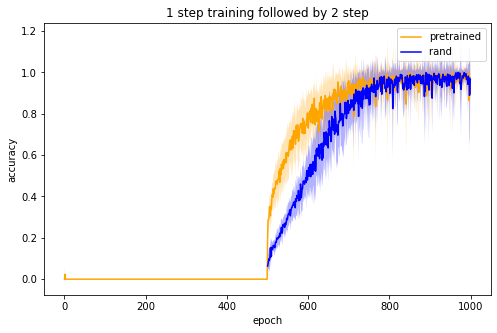

In [45]:
lr = np.array(accs).T
r = np.array(accs_rand).T
plt.figure(figsize=(8,5))
NNplt.plotNN_shifted([lr],\
                    labels = ['pretrained'],\
                    colors = ['orange'],\
                    shift = 0)
NNplt.plotNN_shifted([r],\
                    labels = ['rand '],\
                    colors = ['blue'],\
                    shift = 500)
plt.title('1 step training followed by 2 step')
plt.ylabel('accuracy')

In [42]:
epochs = 500
num_sims = 100

one_shot_acc = []
losses=[]
accs = []
losses_rand = []
accs_rand = []

for j in range(num_sims):
    print('### rep', j, ' ###')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model, train_data123, train_2step, epochs)
    
    acc_1shot = test_acc(model, train_2step, hidden_size, verbose = True)
    one_shot_acc.append(acc_1shot)
    print('----- 1 shot accuracy ------')
    
    model2 = shuffle_weights(model)
    
    loss2, acc2 = run_acc(model, train_2step, train_2step, epochs)
    losses.append(loss1+loss2)
    accs.append(acc1+acc2)
    
    optimizer = torch.optim.Adam(model2.parameters(), lr=learningRate)
    loss3, acc3 = run_acc(model2, train_2step, train_2step, epochs)
    losses_rand.append(loss3)
    accs_rand.append(acc3)


### rep 0  ###
loss: 0.1 
accuracy: 0.0 
test accuracy: 0.000000 
----- 1 shot accuracy ------
loss: 1.4 
accuracy: 1.0 
loss: 30.6 
accuracy: 0.98 
### rep 1  ###
loss: 0.0 
accuracy: 0.0 
test accuracy: 0.000000 
----- 1 shot accuracy ------
loss: 3.5 
accuracy: 0.97 
loss: 2.8 
accuracy: 1.0 
### rep 2  ###
loss: 0.1 
accuracy: 0.0 
test accuracy: 0.000000 
----- 1 shot accuracy ------
loss: 0.9 
accuracy: 1.0 
loss: 3.1 
accuracy: 1.0 
### rep 3  ###
loss: 0.0 
accuracy: 0.0 
test accuracy: 0.000000 
----- 1 shot accuracy ------
loss: 7.8 
accuracy: 1.0 
loss: 11.7 
accuracy: 0.97 
### rep 4  ###
loss: 0.0 
accuracy: 0.0 
test accuracy: 0.000000 
----- 1 shot accuracy ------
loss: 3.2 
accuracy: 1.0 
loss: 4.3 
accuracy: 0.99 
### rep 5  ###
loss: 0.0 
accuracy: 0.0 
test accuracy: 0.000000 
----- 1 shot accuracy ------
loss: 0.5 
accuracy: 1.0 
loss: 31.7 
accuracy: 0.9 
### rep 6  ###
loss: 1.0 
accuracy: 0.0 
test accuracy: 0.000000 
----- 1 shot accuracy ------
loss: 0.7 
accur

KeyboardInterrupt: 

In [30]:
4*3*4*3*4*3*4

6912